In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate


# Read the data
INCIDENTS = '../../dataset/data-raw/incidents.csv'
POVERTYYEAY = '../../dataset/data-raw/povertyByStateYear.csv'
STATEDISHOUSE = '../../dataset/data-raw/year_state_district_house.csv'

incidents = pd.read_csv(INCIDENTS)
poverty = pd.read_csv(POVERTYYEAY)
state_district_house = pd.read_csv(STATEDISHOUSE)



/tmp/ipykernel_2375/3222265658.py:12: DtypeWarning: Columns (15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  incidents = pd.read_csv(INCIDENTS)


## First look at the data
### Columns descriptions
#### Incidents DS

| Column name               | Description                                                                                  | Notes                                   |
|---------------------------|----------------------------------------------------------------------------------------------|-----------------------------------------|
| date                      | Date of the incident YYYY-MM-DD                                                              | Split into 3 columns (year, month, day) |
| state                     | State in which the incident occurred                                                         | Converted to UPPER-CASE                 |
| city_or_county            | self-explanatory                                                                             |                                         |
| address                   | self-explanatory                                                                             |                                         |
| latitude                  | self-explanatory                                                                             |                                         |
| longitude                 | self-explanatory                                                                             |                                         |
| congressional_district    | Congressional district associated to the location                                            |                                         |
| state_house_district      | self-explanatory                                                                             |                                         |
| state_senate_district     | self-explanatory                                                                             |                                         |
| participant_age1          | Age of 1 (randomly choosen) participant                                                      |                                         |
| participant_age_group1    | Age group of 1 (randomly choosen) participant in ['Adult 18+' nan 'Teen 12-17' 'Child 0-11'] |                                         |
| participant_gender1       | Gender of 1 (randomly choosen) participant                                                   |                                         |
| min_age_participants      |                                                                                              |                                         |
| avg_age_participants      |                                                                                              |                                         |
| max_age_participants      |                                                                                              |                                         |
| n_participants_child      |                                                                                              |                                         |
| n_participants_teen       |                                                                                              |                                         |
| n_participants_adult      |                                                                                              |                                         |
| n_males                   |                                                                                              |                                         |
| n_females                 |                                                                                              |                                         |
| n_killed                  |                                                                                              |                                         |
| n_injured                 |                                                                                              |                                         |
| n_arrested                |                                                                                              |                                         |
| n_unharmed                |                                                                                              |                                         |
| n_participants            |                                                                                              |                                         |
| notes                     |                                                                                              |                                         |
| incident_characteristics1 |                                                                                              |                                         |
| incident_characteristics2 |                                                                                              |                                         |
|                           |                                                                                              |                                         |
|                           |                                                                                              |                                         |


Show an aggregate description of each column 

In [2]:
for name, df in [('incidents', incidents), ('poverty', poverty), ('state_district_house', state_district_house)]:
    print(f"----- {name} head -----")
    print(tabulate(df.head(), headers='keys', tablefmt='psql'))

----- incidents head -----
+----+------------+----------------------+------------------+------------------------------------+------------+-------------+--------------------------+------------------------+-------------------------+--------------------+--------------------------+-----------------------+------------------------+------------------------+------------------------+------------------------+-----------------------+------------------------+-----------+-------------+------------+-------------+--------------+--------------+------------------+------------------------------------------------------------------------------+-------------------------------------------+--------------------------------------+
|    | date       | state                | city_or_county   | address                            |   latitude |   longitude |   congressional_district |   state_house_district |   state_senate_district |   participant_age1 | participant_age_group1   | participant_gender1   |   min_ag

In [4]:
for name, df in [('incidents', incidents), ('poverty', poverty), ('state_district_house', state_district_house)]:
    print(f"----- {name} non-numeric columns unique values -----")
    for col in df.select_dtypes(include=['object']).columns:
        print(f"{col}:\n\tUnique cardinality: {df[col].unique().shape[0]}\n\t{df[col].unique()}")

----- incidents non-numeric columns unique values -----
date:
	Unique cardinality: 2437
	['2015-05-02' '2017-04-03' '2016-11-05' ... '2013-07-24' '2013-12-14'
 '2013-04-18']
state:
	Unique cardinality: 51
	['Indiana' 'Pennsylvania' 'Michigan' 'District of Columbia'
 'North Carolina' 'Louisiana' 'Connecticut' 'Virginia' 'Oklahoma'
 'New York' 'Missouri' 'California' 'Texas' 'Illinois' 'Ohio' 'Washington'
 'Florida' 'South Carolina' 'Georgia' 'Massachusetts' 'Tennessee'
 'West Virginia' 'New Jersey' 'Arkansas' 'Rhode Island' 'Maine' 'Nevada'
 'Colorado' 'New Mexico' 'Maryland' 'Oregon' 'South Dakota' 'Kentucky'
 'Alabama' 'Arizona' 'Minnesota' 'Wisconsin' 'Mississippi' 'Kansas' 'Iowa'
 'Wyoming' 'Nebraska' 'Alaska' 'Utah' 'Montana' 'Hawaii' 'Delaware'
 'Idaho' 'New Hampshire' 'Vermont' 'North Dakota']
city_or_county:
	Unique cardinality: 12898
	['Indianapolis' 'Kane' 'Detroit' ... 'Emporium' 'Conecuh (county)'
 'Somerset County']
address:
	Unique cardinality: 198038
	['Lafayette Road and

In [3]:

incidents['state'] = incidents['state'].str.upper()
poverty['state'] = poverty['state'].str.upper()
state_district_house['state'] = state_district_house['state'].str.upper()

incidents['date_year'] = incidents['date'].str.split('-').str[0].astype(int)
incidents['date_month'] = incidents['date'].str.split('-').str[1].astype(int)
incidents['date_day'] = incidents['date'].str.split('-').str[2].astype(int)
del incidents['date']

# reorder columns with date_year, date_month, date_day at the start
cols = list(incidents.columns.values)
cols.pop(cols.index('date_year'))
cols.pop(cols.index('date_month'))
cols.pop(cols.index('date_day'))
incidents = incidents[['date_year', 'date_month', 'date_day'] + cols]

In [6]:
for name, df in [('incidents', incidents), ('poverty', poverty), ('state_district_house', state_district_house)]:
    df = df.copy()
    print(f"----- {name} summary -----")
    print(f"records: {df.shape[0]}")
    colsumpd = pd.DataFrame(index=df.columns)
    colsumpd['not_null'] = df.notnull().sum()
    colsumpd['unique'] = df.nunique()
    colsumpd['null_count'] = df.isnull().sum()
    colsumpd['null_perc'] = (colsumpd['null_count'] / df.shape[0] * 100).round(2)
    colsumpd['type'] = (df.dtypes.astype(str)).str.upper()
    numeric_df = df.apply(pd.to_numeric, errors='coerce').describe()
    numeric_df.index = ['numeric_' + str(row) for row in numeric_df.index]
    # round all values of numeric_df to 4 decimal places
    numeric_df = numeric_df.round(4)
    # merge the two dataframes on common columns
    colsumpd = pd.merge(colsumpd, numeric_df.T, left_index=True, right_index=True, how='outer')
    colsumpd['not_num_count'] = colsumpd['not_null'] - colsumpd['numeric_count']
    colsumpd['not_num_perc'] = (colsumpd['not_num_count'] / colsumpd['not_null'] * 100).round(2)
    print(tabulate(colsumpd.T, headers='keys', tablefmt='pipe', numalign='left', stralign='left'))


----- incidents summary -----
records: 239677
|               | date_year   | date_month   | date_day   | state    | city_or_county   | address   | latitude   | longitude   | congressional_district   | state_house_district   | state_senate_district   | participant_age1   | participant_age_group1   | participant_gender1   | min_age_participants   | avg_age_participants   | max_age_participants   | n_participants_child   | n_participants_teen   | n_participants_adult   | n_males   | n_females   | n_killed   | n_injured   | n_arrested   | n_unharmed   | n_participants   | notes          | incident_characteristics1   | incident_characteristics2   |
|:--------------|:------------|:-------------|:-----------|:---------|:-----------------|:----------|:-----------|:------------|:-------------------------|:-----------------------|:------------------------|:-------------------|:-------------------------|:----------------------|:-----------------------|:-----------------------|:------------------

### Results
#### incidents dataframe

1. NAN analysis
    - Most columns are `poisoned` with NANs
    - The worst columns are `(min|avg|max)_age_participants`, with +30% of NANs
2. Types analysis
    - `(min|avg|max)_age_participants` and `n_participants_(child|teen|adult)` are classified as `object` but they should have a numeric dtype. This suggests a mix of types
    - `(min|avg|max)_age_participants` have roughly 3.5% of non-numeric non-NAN values. This values are not convertible to numeric.
3. Range analysis
    - `date_year` max value is in the future.
    - The min-max values of the columns `[participant_age1, (min|avg|max)_age_participants, n_participants_(child|teen|adult)]` are beyond the expected ranges.

#### poverty / state_district_house dataframes

This dataframes do not raise any red flags on this preliminary analysis.

## Columns filter
Select which columns to keep for the analysis
### Incidents
We keep `['date', 'state', 'city_or_county', 'latitude', 'longitude', 'congressional_district', 'n_participants_child', 'n_participants_teen', 'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured', 'n_arrested', 'n_unharmed', 'n_participants', 'incident_characteristics1']`
### Poverty
We keep everything
### State District House
We keep everything

In [15]:
fincidents = incidents[['date_year', 'date_month', 'date_day', 'state', 'city_or_county', 'latitude', 'longitude', 'congressional_district', 'n_participants_child', 'n_participants_teen', 'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured', 'n_arrested', 'n_unharmed', 'n_participants', 'incident_characteristics1']].copy()
print(f"All rows count: {fincidents.shape[0]}")
fincidents = fincidents[fincidents['n_participants'] != 0]
print(f"Zero participants removed: {fincidents.shape[0]}")
# fincidents[~fincidents.isna().any(axis=1)]
na_counts = fincidents.isna().sum(axis=1)

print(f"nan percentages:\n{na_counts.value_counts().sort_index() / fincidents.shape[0] * 100}")

fincidents[(na_counts > 6)].shape

All rows count: 239677
Zero participants removed: 214814
nan percentages:
0     84.764494
1      1.437057
2      2.443975
3      7.568874
4      0.114518
5      2.872718
6      0.188070
7      0.522312
8      0.085190
10     0.002793
Name: count, dtype: float64


(1311, 19)

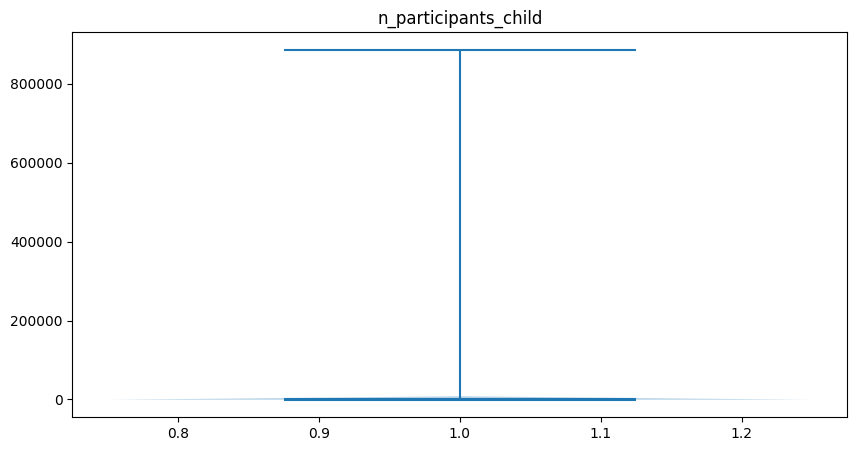

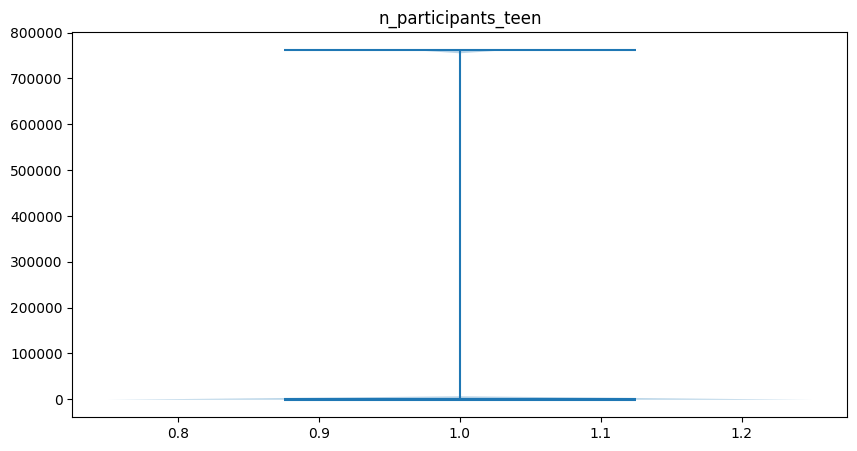

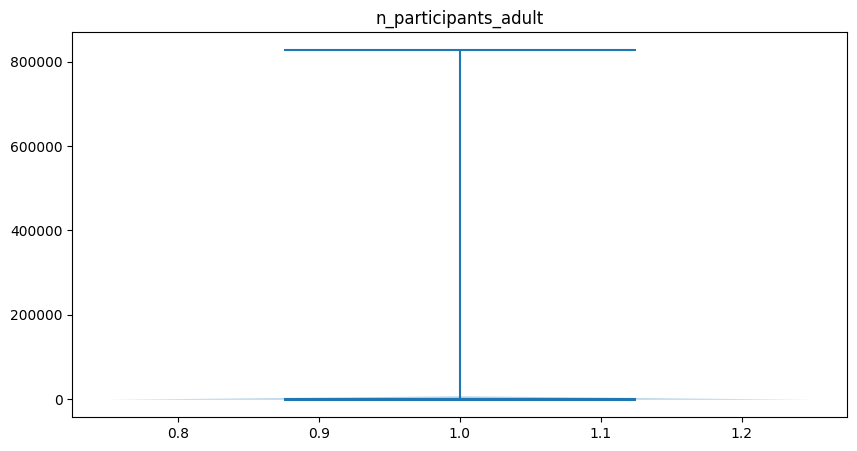

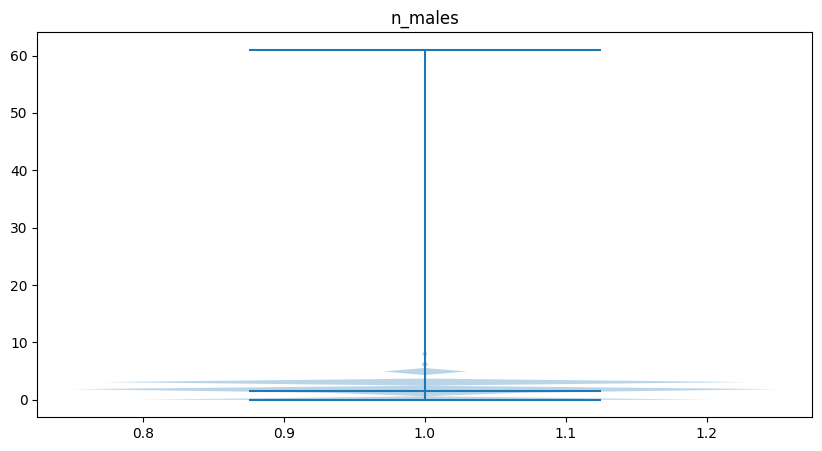

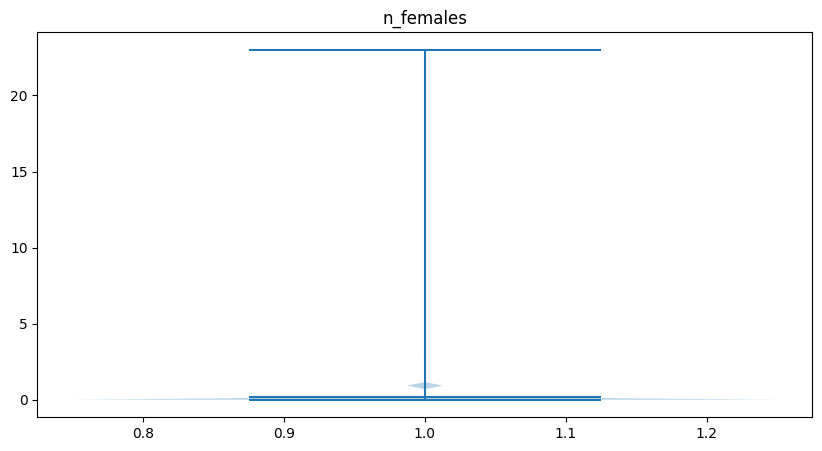

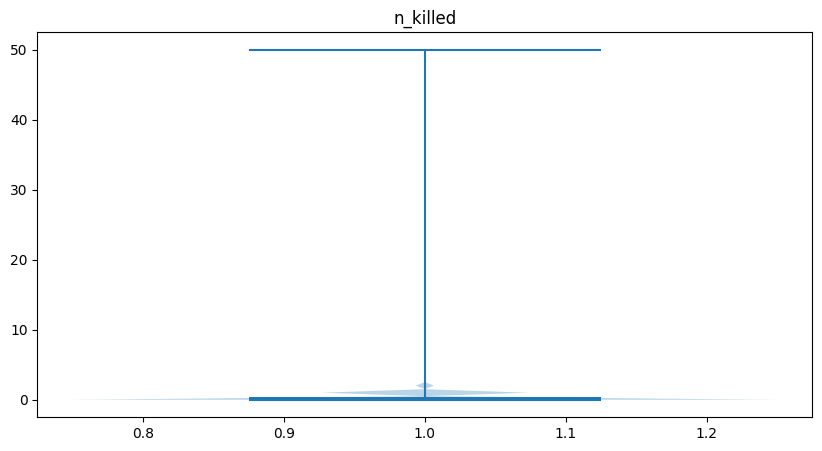

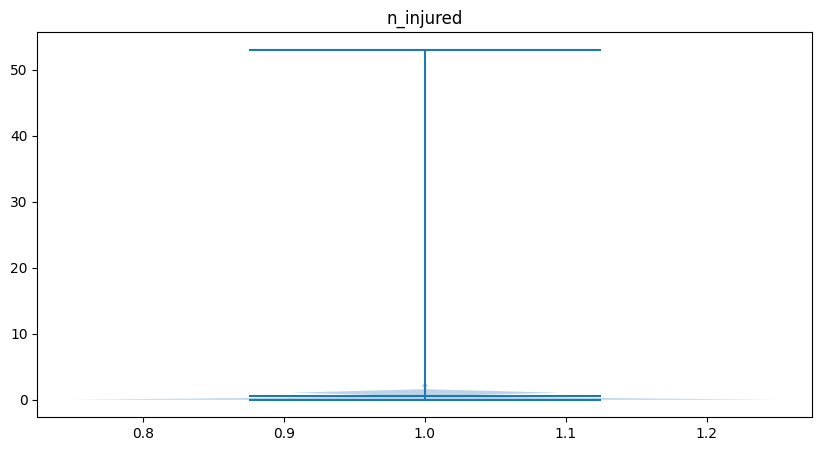

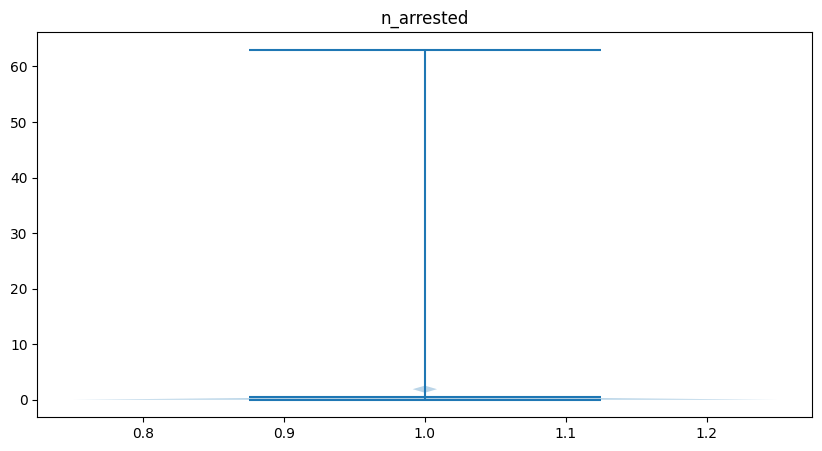

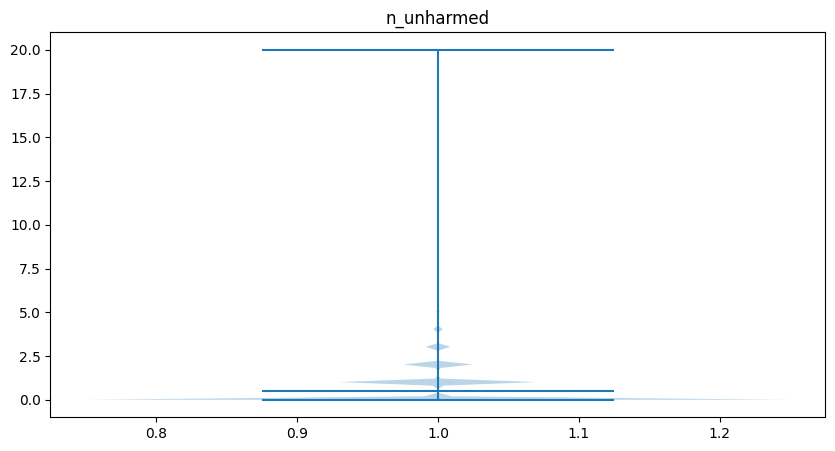

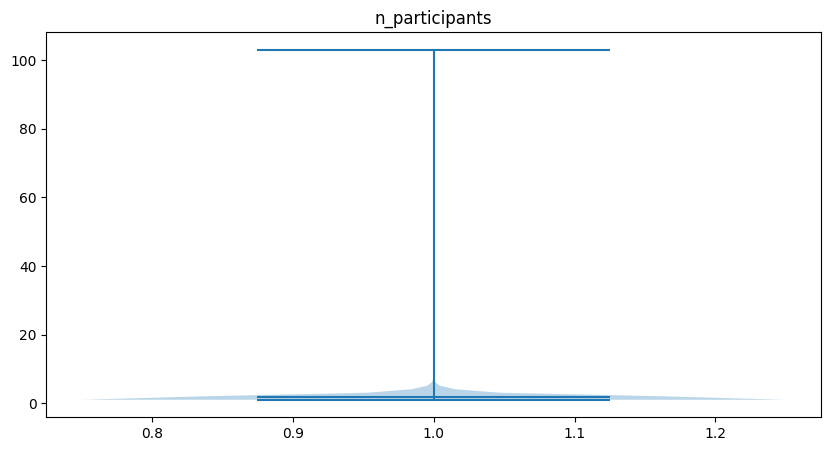

In [22]:
for col in ['n_participants_child', 'n_participants_teen', 'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured', 'n_arrested', 'n_unharmed', 'n_participants']:
    tmpcol = fincidents[col].copy()
    # remove non-numeric values
    tmpcol = tmpcol.apply(pd.to_numeric, errors='coerce')
    plt.figure(figsize=(10, 5))
    plt.title(col)
    plt.violinplot(tmpcol[~tmpcol.isna()], showmeans=True)
    plt.show()

In [5]:
incidents.columns

Index(['date_year', 'date_month', 'date_day', 'state', 'city_or_county',
       'address', 'latitude', 'longitude', 'congressional_district',
       'state_house_district', 'state_senate_district', 'participant_age1',
       'participant_age_group1', 'participant_gender1', 'min_age_participants',
       'avg_age_participants', 'max_age_participants', 'n_participants_child',
       'n_participants_teen', 'n_participants_adult', 'n_males', 'n_females',
       'n_killed', 'n_injured', 'n_arrested', 'n_unharmed', 'n_participants',
       'notes', 'incident_characteristics1', 'incident_characteristics2'],
      dtype='object')

In [29]:
cities = incidents['city_or_county'].unique()

i_d = incidents[['state', 'city_or_county', 'congressional_district', 'date_year']].copy()
i_d['sc'] = i_d.apply(lambda row: f"{row['state']}-{row['city_or_county']}", axis=1)
i_d['scd'] = i_d.apply(lambda row: f"{row['state']}-{row['city_or_county']}-{row['congressional_district']}", axis=1)
i_d = i_d.sort_values(by=['sc'])
# keep only one record per scd
# i_d = i_d.drop_duplicates(subset=['scd'])
i_d

,state,city_or_county,congressional_district,date_year,sc,scd
164385,ALABAMA,Abbeville,2.0,2017,ALABAMA-Abbeville,ALABAMA-Abbeville-2.0
62332,ALABAMA,Abbeville,2.0,2016,ALABAMA-Abbeville,ALABAMA-Abbeville-2.0
63398,ALABAMA,Adamsville,6.0,2017,ALABAMA-Adamsville,ALABAMA-Adamsville-6.0
184456,ALABAMA,Adamsville,6.0,2016,ALABAMA-Adamsville,ALABAMA-Adamsville-6.0
162152,ALABAMA,Adamsville,6.0,2029,ALABAMA-Adamsville,ALABAMA-Adamsville-6.0
...,...,...,...,...,...,...
58436,WYOMING,Torrington,1.0,2015,WYOMING-Torrington,WYOMING-Torrington-1.0
24919,WYOMING,Washakie (county),1.0,2015,WYOMING-Washakie (county),WYOMING-Washakie (county)-1.0
164127,WYOMING,Washakie (county),1.0,2015,WYOMING-Washakie (county),WYOMING-Washakie (county)-1.0
103473,WYOMING,Worland,1.0,2017,WYOMING-Worland,WYOMING-Worland-1.0


In [26]:
incidents[incidents['city_or_county'] == 'Detroit']

,date_year,date_month,date_day,state,city_or_county,address,latitude,longitude,congressional_district,state_house_district,...,n_males,n_females,n_killed,n_injured,n_arrested,n_unharmed,n_participants,notes,incident_characteristics1,incident_characteristics2
2,2016,11,5,MICHIGAN,Detroit,6200 Block of East McNichols Road,42.4190,-83.0393,14.0,4.0,...,NaN,NaN,0,1,0.0,1.0,2.0,1 inj.,Shot - Wounded/Injured,NaN
28,2014,8,11,MICHIGAN,Detroit,2900 block of Buena Vista,42.3899,-83.1236,13.0,7.0,...,1.0,0.0,0,1,0.0,1.0,2.0,Child shoots father when as he commits domesti...,Shot - Wounded/Injured,Accidental Shooting
127,2015,6,14,MICHIGAN,Detroit,Grand River and Shiawassee,42.4226,-83.2725,13.0,9.0,...,0.0,1.0,0,1,0.0,0.0,1.0,Non drive-by random shooting injures woman wal...,Shot - Wounded/Injured,Possession (gun(s) found during commission of ...
215,2018,2,24,MICHIGAN,Detroit,2500 BLOCK OF BENITEAU ST,42.3712,-82.9749,14.0,2.0,...,NaN,NaN,0,0,NaN,NaN,0.0,NaN,Shots Fired - No Injuries,NaN
342,2018,2,18,MICHIGAN,Detroit,8000 BLOCK OF VAUGHAN S,42.3503,-83.2369,13.0,9.0,...,NaN,NaN,0,0,NaN,NaN,0.0,NaN,Shots Fired - No Injuries,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238795,2018,2,25,MICHIGAN,Detroit,2000 block of Park Ave,42.3365,-83.0523,NaN,NaN,...,2.0,0.0,0,1,0.0,1.0,2.0,NaN,Shot - Wounded/Injured,NaN
238879,2017,8,11,MICHIGAN,Detroit,7400 Block of Central Ave,42.3472,-83.1456,13.0,5.0,...,1.0,1.0,2,0,0.0,0.0,2.0,"42.348419, -83.146086 ;","Shot - Dead (murder, accidental, suicide)","Drive-by (car to street, car to car)"
239579,2014,5,9,MICHIGAN,Detroit,15000 block of Iliad Street,42.4008,-83.2712,13.0,9.0,...,2.0,0.0,1,0,0.0,1.0,2.0,NaN,"Shot - Dead (murder, accidental, suicide)",NaN
239628,2018,2,21,MICHIGAN,Detroit,12800 BLOCK OF ESSEX AVE,42.3633,-82.9507,NaN,NaN,...,NaN,NaN,0,0,NaN,NaN,0.0,NaN,Shots Fired - No Injuries,NaN


In [37]:
df = i_d[(i_d['state'] == 'COLORADO') * (i_d['city_or_county'] == 'Denver')]
# df['congressional_district'].value_counts().idxmax()
df[pd.isna(df['congressional_district'])]

,state,city_or_county,congressional_district,date_year,sc,scd
99384,COLORADO,Denver,NaN,2016,COLORADO-Denver,COLORADO-Denver-nan
70999,COLORADO,Denver,NaN,2016,COLORADO-Denver,COLORADO-Denver-nan
42559,COLORADO,Denver,NaN,2018,COLORADO-Denver,COLORADO-Denver-nan
24126,COLORADO,Denver,NaN,2016,COLORADO-Denver,COLORADO-Denver-nan
59628,COLORADO,Denver,NaN,2015,COLORADO-Denver,COLORADO-Denver-nan
216209,COLORADO,Denver,NaN,2017,COLORADO-Denver,COLORADO-Denver-nan
135672,COLORADO,Denver,NaN,2016,COLORADO-Denver,COLORADO-Denver-nan
47474,COLORADO,Denver,NaN,2016,COLORADO-Denver,COLORADO-Denver-nan
54200,COLORADO,Denver,NaN,2017,COLORADO-Denver,COLORADO-Denver-nan
82666,COLORADO,Denver,NaN,2016,COLORADO-Denver,COLORADO-Denver-nan


In [38]:
das = incidents[incidents['n_participants'] == 0]